In [6]:
import pandas as pd
import glob
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn')



/tmp/ipykernel_2623693/2209360486.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [7]:
translation = {"x_0":"Season",
               "x_1":"Year",
               "x_2": "Month",
               "x_3": "Holiday",
               "x_4": "Weekday", 
               "x_5": "Working day",
               "x_6": "Weather Situation",
               "x_7": "Temperature",
               "x_8": "Feeling Temperature",
               "x_9": "Humidity",
               "x_10": "Windspeed"}

def replace_translation(stri, d, reverse):

    for k in sorted(d.keys(), reverse=reverse):
        stri = stri.replace(str(k), str(d[k]))
    return stri

In [70]:
from collections import defaultdict

function_per_dataset = defaultdict(list)
for dataset in ["air", "bike", "concrete", "dowchemical", "tower", "synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]:
    nr_exprs = 0
    nr_dupls = 0
    nr_funcs = 0
    size_reason = 0
    
    nr_dupls2 = 0

    def find_duplicates(lst):
        # Count occurrences of each element in the list
        counter = Counter(lst)
        # Filter and return elements that have more than one occurrence
        duplicates = [item for item, count in counter.items() if count > 1]
        
        dupl_count = 0
        for _, count in counter.items():
            if count>1:
                dupl_count += count - 1
                
        return duplicates, dupl_count
    
    def replace_any(stri):
        stri = stri.replace("any[", "any{")

        bracket_counter = 0
        replacement_indices = []
        found = []
        for idx, char in enumerate(stri):
            if char == "[":
                bracket_counter += 1
            if char == "]":
                bracket_counter -= 1
                if bracket_counter in found:
                    found.remove(bracket_counter)
                    replacement_indices.append(idx)

            if char == "{":
                found.append(bracket_counter)
                bracket_counter += 1

        stri = list(stri)
        for idx in replacement_indices:
            stri[idx] = "}"

        return ''.join(stri)
    
    def replace_any_with_x(s):
        result = []
        stack = []
        i = 0

        while i < len(s):
            if s[i:i+4] == 'any{':
                stack.append(i)
                result.append('any{x}')
                i += 4
                while stack:
                    if s[i:i+4] == 'any{':
                        stack.append(i)
                        i += 4
                    elif s[i] == '}':
                        stack.pop()
                        i += 1
                    else:
                        i += 1
            else:
                result.append(s[i])
                i += 1

        return ''.join(result)

    def remove_any_expressions(s):
        def recursive_remove(sub_s):
            result = []
            stack = []
            i = 0

            while i < len(sub_s):
                if sub_s[i:i+4] == 'any{':
                    stack.append(i)
                    i += 4
                elif sub_s[i] == '}' and stack:
                    start = stack.pop()
                    if not stack:
                        i += 1  # Skip the closing bracket of 'any[' block
                elif not stack:
                    result.append(sub_s[i])
                    i += 1
                else:
                    result.append(sub_s[i])
                    i += 1

            result_str = ''.join(result)
            if 'any{' in result_str:
                return recursive_remove(result_str)
            else:
                return result_str

        return recursive_remove(s)


    def find_func_calls(s):
        result = []

        def extract_func_calls(sub_s):
            stack = []
            start = 0
            while start < len(sub_s):
                if sub_s[start:start+5] == 'func[':
                    stack.append(start)
                    start += 5
                elif sub_s[start] == ']' and stack:
                    opening = stack.pop()
                    if not stack:
                        inner_expression = sub_s[opening+5:start]
                        result.append(inner_expression)
                        # Recursively extract any nested func calls
                        extract_func_calls(inner_expression)
                    start += 1
                else:
                    start += 1

   
        extract_func_calls(s)
        return result

    functions = []
    # Loop over all files
    for filename in glob.glob("./results/final/*SO_4_4_{}.csv".format(dataset)):
        nr = filename.split("/")[-1].split("_")[0]
        d_key = "_".join(filename.split("/")[-1].split("_")[1:]).replace(dataset,"").replace(".csv","")
        df = pd.read_csv(filename, sep="\t", header=None)
    
        # Read string from file
        stri = df.iloc[0][6]
        
        # Replace any[ and matching bracket with any{}
        stri = replace_any(stri)
        
        # Recursively obtain list of subexpressions
        subexpressions = find_func_calls(stri)
            
        # Replace any{subexpressions} non-recursively with any{x}
        subexpressions_any_x = []
        for subexpression in subexpressions:
            subexpressions_any_x.append(replace_any_with_x(subexpression))
        
        nr_exprs += 1

        nr_funcs += len(subexpressions_any_x)
        
#         print()
#         print(subexpressions_any_x)
        dupls, dupl_count = find_duplicates(subexpressions_any_x)
#         print()
#         print(dupls)
        
        nr_dupls += dupl_count

        if(float(df.iloc[-1][3])>31):
            size_reason += len(subexpressions)
            
        if (len(dupls)>0):
            functions.append(replace_translation(dupls[0], translation, True))
            
    if(nr_exprs>0):
        print(dataset, nr_funcs/nr_exprs, nr_dupls/nr_exprs, size_reason/nr_exprs)
    
    function_per_dataset[dataset].extend(functions)
    


air 4.9 1.9666666666666666 4.9
bike 4.333333333333333 1.3666666666666667 4.333333333333333
concrete 5.233333333333333 2.3333333333333335 5.233333333333333
dowchemical 3.933333333333333 1.0333333333333334 3.933333333333333
tower 4.3 1.6 4.3
synthetic_1 2.2333333333333334 0.23333333333333334 2.066666666666667
synthetic_2 8.866666666666667 6.066666666666666 8.866666666666667
synthetic_3 5.766666666666667 3.1333333333333333 5.033333333333333
synthetic_4 4.133333333333334 1.3666666666666667 3.033333333333333
synthetic_5 4.5 2.2666666666666666 3.0


In [69]:
instance = {"Season":1,
"Year":0,
"Month":1,
"Holiday":0,
"Weekday":6,
"Working day":0,
"Weather Situation":"x",
"Temperature":0.34,
"Feeling Temperature":0.36,
"Humidity": 0.8,
"Windspeed":0.16}

functional = {
    "sin":"np.sin",
    "sqrt":"np.sqrt",
    "cos":"np.cos",
    "ln":"np.log",
    "func[(": "",
    ")]": "",
    "any[": "",
    "]": ""
}

In [64]:
print(function_per_dataset["bike"])
function = replace_translation(function_per_dataset["bike"][2], instance, False)
function = replace_translation(function, functional, False)
print(function)

['(((cos(Year)+(Weather Situation/any{x}))/((Weather Situation/Windspeed)-cos(Weekday)))-(((3.123930931-Year)+any{x})*func[(sin(Feeling Temperature)/(Feeling Temperature+abs(cos(Weather Situation))))]))', '((sin((Season/4.971846104))-cos((Temperature/-0.192960218)))-func[((cos((Holiday*Temperature))-sin(sin(Weather Situation)))+func[(abs(((Windspeed/-0.644937336)/cos(Humidity)))-sqrt(((Year/Weather Situation)*cos(any{x}))))])])', '(abs(((any{x}+2.496052742)+(any{x}--6.224753857)))-(sin((Temperature*7.594888210))+((Windspeed+Windspeed)-sin(Weather Situation))))', '((ln((3.821305275-Year))/(sqrt(4.061196327)-(Weather Situation*any{x})))+sin((cos(Temperature)*abs(5.892477512))))', '((sin((Season-2.955377102))*((any{x}/-0.548183382)-1.783771038))+(((3.537945509+any{x})*(2.858294487+Season))-sin((-13.296705246*Temperature))))', '(cos(((2.216444492-any{x})+ln(Windspeed)))+(((Humidity*1.979304671)/ln(Windspeed))-(Holiday+cos(any{x}))))', '(((4.606641769+(Year-Windspeed))*sin(abs(-16.549200058

ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

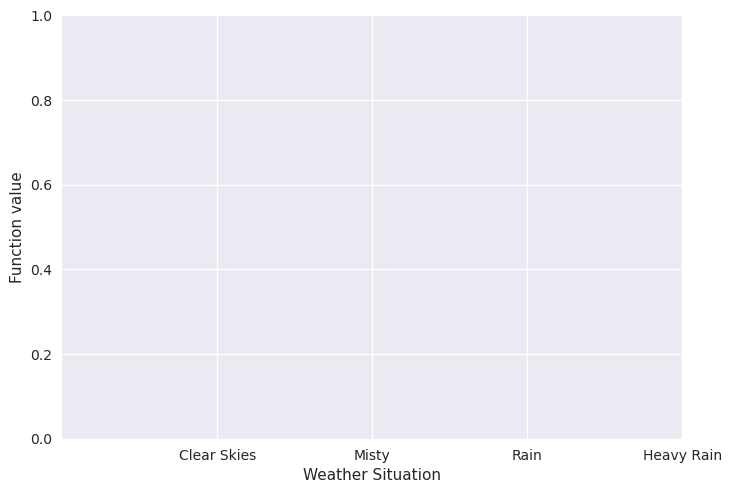

In [47]:
func = lambda x: eval(function)
x = np.linspace(0,4,100)
y = func(x)
plt.figure()
plt.xlabel("Weather Situation")
xtick_locations = [1,2,3,4]
xtick_labels = ["Clear Skies", "Misty", "Rain", "Heavy Rain"]
plt.xticks(xtick_locations, xtick_labels)
plt.ylabel("Function value")
plt.plot(x,y)
plt.show()

In [ ]:
dataset = "bike"

def extract_substrings(text):
    return re.findall(r'func\[(.*?)\]', text)

functions = []
for filename in glob.glob("./results/cmp/*_MO_*k2*_bike.csv"):
    nr = filename.split("/")[-1].split("_")[0]
    d_key = "_".join(filename.split("/")[-1].split("_")[1:]).replace(dataset,"").replace(".csv","")
    df = pd.read_csv(filename, sep="\t", header=None)
    
    
    substrings = extract_substrings(df.iloc[0][5])
    if (count_duplicates_in_list(substrings)>0):
        print(substrings[0])
        print("")
        functions.append(replace_translation(substrings[0], translation, True))
        
    

In [ ]:
instance = {"Season":1,
"Year":0,
"Month":1,
"Holiday":0,
"Weekday":6,
"Working day":0,
"Weather Situation":2,
"Temperature":"x",
"Feeling Temperature":0.36,
"Humidity": 0.8,
"Windspeed":0.16}

functional = {
    "sin":"np.sin",
    "sqrt":"np.sqrt",
    "cos":"np.cos",
    "ln":"np.log",
    "func[(": "",
    ")]": ""
}

In [ ]:
print(functions[2])
function = replace_translation(functions[2], instance, False)
function = replace_translation(function, functional, False)[1:]
print(function)

In [ ]:
func = lambda x: eval(function)
x = np.linspace(0,1,100)
y = func(x)
plt.figure()
plt.xlabel("Temperature (Celsius)")
xtick_locations = [0.,0.2,0.4,0.6,0.8,1.0]
conversion = lambda z: z * 47 - 8
xtick_labels = ["{:.1f}".format(conversion(z)) for z in xtick_locations]
plt.xticks(xtick_locations, xtick_labels)
plt.ylabel("Function value")
plt.plot(x,y)
plt.show()

In [32]:


print(find_func_calls("10 + func[func[any[5]] + 6]"))

['func[5] + 6', '5']


In [65]:
for dataset in ["synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]:
    print(dataset.upper())
    for filename in glob.glob("./results/final/*SO_4_4_{}.csv".format(dataset)):
        nr = filename.split("/")[-1].split("_")[0]
        d_key = "_".join(filename.split("/")[-1].split("_")[1:]).replace(dataset,"").replace(".csv","")
        df = pd.read_csv(filename, sep="\t", header=None)

        if(df.iloc[-1][1]==0):
            print(df.iloc[-1][6])
            print()
    
    print("FAILURES")
    for filename in glob.glob("./results/final/*SO_4_4_{}.csv".format(dataset)):
        nr = filename.split("/")[-1].split("_")[0]
        d_key = "_".join(filename.split("/")[-1].split("_")[1:]).replace(dataset,"").replace(".csv","")
        df = pd.read_csv(filename, sep="\t", header=None)

        if(df.iloc[-1][1]!=0):
            print(df.iloc[-1][6])

SYNTHETIC_1
(0.000000+(1.000000*((sin((x_8+x_0))+sin((x_0+x_7)))+(sin((x_0+x_1))+func[(func[((sin((x_0+x_3))+sin((any[x_6]+x_0)))+(sin((x_2+x_0))+sin((x_5+x_0))))]+sin(any[(x_0+x_4)]))]))))

(0.000000+(1.000000*((sin((x_8+x_0))+sin((x_0+x_6)))+(sin((x_2+x_0))+func[((sin((any[x_4]+x_0))+sin(abs(any[(x_0+x_3)])))+func[((sin((x_0+x_7))+sin((x_5+x_0)))+sin(abs((x_0+x_1))))])]))))

(0.000000+(1.000000*((sin((x_7+x_0))+sin((x_0+x_8)))+(sin((x_0+x_2))+(func[sin((any[x_0]+any[x_1]))]+func[((sin((any[x_6]+x_0))+sin((x_5+x_0)))+func[any[(func[sin((any[x_3]+any[x_0]))]+func[sin((any[x_4]+any[x_0]))])]])])))))

(0.000000+(1.000000*((sin((x_0+x_7))+sin((x_0+x_8)))+(sin((x_0+x_6))+func[(sin(abs((x_4+x_0)))+func[((sin((x_2+x_0))+sin((x_1+x_0)))+(sin((x_3+x_0))+sin((x_5+x_0))))])]))))

(0.000000+(1.000000*((sin((x_0+x_6))+sin((x_0+x_8)))+((func[sin((any[x_4]+x_0))]+func[((sin((any[x_0]+x_1))+sin((x_0+x_5)))+(sin((x_0+x_2))+sin((any[x_0]+x_3))))])+sin((x_0+x_7))))))

(0.000000+(1.000000*((sin((x_2+x_0)

(0.000000+(1.000000*((sin((x_1*x_0))*(func[((cos(cos(any[x_0]))+sqrt((x_0/x_0)))+(sqrt((x_1/x_1))+cos(sin(any[x_0]))))]+func[((cos(cos(any[x_1]))+sqrt((x_0/x_0)))+(sqrt((x_1/x_1))+cos(sin(any[x_1]))))]))+sin(func[(x_3*x_2)]))))
SYNTHETIC_3
(0.000000+(1.000000*((func[sqrt(abs(sin((x_0*x_1))))]+abs(func[sqrt(abs(sin((x_0*any[x_2]))))]))+abs(func[(abs(func[sqrt(abs(sin((x_0*any[abs(x_4)]))))])+abs(any[func[sqrt(abs(sin((x_0*any[x_3]))))]]))]))))

(0.000000+(1.000000*(func[abs(abs((abs(any[abs(func[sqrt(abs(sin((x_0*any[x_3]))))])])+func[sqrt(abs(sin((x_0*any[x_2]))))])))]+(func[sqrt(abs(sin((x_0*any[abs(x_1)]))))]+abs(func[sqrt(abs(sin((x_0*any[x_4]))))])))))

(0.000000+(1.000000*((sqrt((x_2-x_2))+func[sqrt(abs(sin((x_1*x_0))))])+(abs(func[abs(abs((func[sqrt(abs(sin((x_0*any[x_2]))))]+func[sqrt(abs(sin((x_0*any[x_4]))))])))])+abs(func[sqrt(abs(sin((x_0*any[x_3]))))])))))

(0.000000+(1.000000*((func[abs(abs(abs(func[sqrt(abs(sin((x_0*any[x_3]))))])))]+abs(func[sqrt(abs(sin((x_0*any[x_1])))

(0.000000+(1.000000*(sqrt((func[((((x_0+x_1)*cos(x_0))*cos((x_0*x_1)))*cos(((x_0+x_1)-(x_2+x_3))))]/func[((((x_0+x_1)*cos(x_0))*cos((x_0*x_1)))*cos(((x_0+x_1)-(x_2+x_3))))]))+cos(sin(func[sqrt((abs(func[((((x_0+x_1)*cos(x_0))*cos((x_0*x_1)))*cos(((x_0+x_1)-(x_2+x_3))))])*((x_3+x_2)/cos(x_0))))])))))
(0.000000+(1.000000*(cos(func[sin((sin((x_1+x_0))*sin((x_3+x_2))))])+cos((func[cos((func[sin((sqrt(cos(x_1))+sin(cos(any[cos(x_3)]))))]*func[sin((sqrt(cos(x_1))+sin(cos(any[(x_0*x_0)]))))]))]-func[sin((sqrt(cos(x_1))+sin(cos(any[x_0]))))])))))
(0.000000+(1.000000*(cos((func[sqrt((sqrt(sin(any[x_0]))*cos(func[cos(((any[x_0]*(x_3+any[x_2]))*cos((x_3*any[x_2]))))])))]*func[(sin(((x_3+x_2)/cos(x_1)))*sin(((x_0+x_1)+sin(x_1))))]))+sqrt(sin(func[cos(((any[x_1]*(x_3+any[x_2]))*cos((x_3*any[x_2]))))])))))
(0.000000+(1.000000*(cos((func[sin((sin((x_1+x_0))*sin((x_3+x_2))))]*func[sqrt((func[sin((sin((x_1+x_0))*sin((x_3+x_2))))]*func[sin((sin((x_1+x_0))*sin((x_3+x_2))))]))]))+sqrt(func[sin(cos(sqrt(an

(0.000000+(1.000000*(((func[cos((sqrt((x_1*x_1))*sin((x_2+x_0))))]+func[cos((sqrt((x_1*x_1))*sin((x_2+x_0))))])+func[cos(sin(((any[func[cos(((func[cos(sin(((any[x_0]*x_0)*(x_2+x_1))))]*(any[x_1]+x_2))-(func[cos((sqrt((x_1*x_1))*sin((x_2+x_0))))]*x_0)))]]*x_0)*(x_2+x_1))))])+func[cos(sin(((any[func[cos(sin(((any[cos(x_0)]*x_0)*(x_2+x_1))))]]*x_0)*(x_2+x_1))))])))
